<a href="https://colab.research.google.com/github/mzs0153/ELEC-7970-Reinforcement-Learning/blob/main/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# We will write codes on Tensorflow 2. 

At first, we will learn how to create a neural network model using Keras functional API. One can also use Keras Sequential API. 

# Import Necessary Libraries

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Helper libraries
import numpy as np


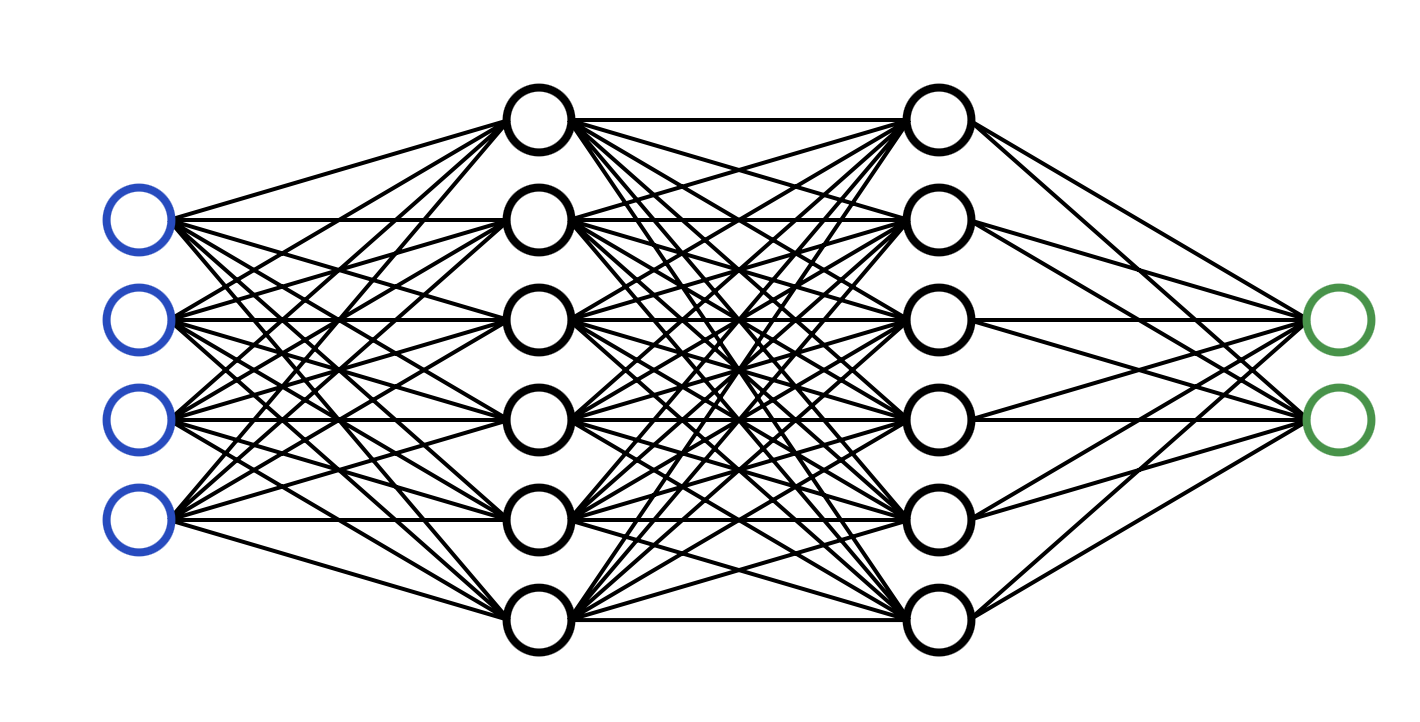

# Neural Network Using Keras Functional API

In [ ]:
inputs=keras.Input(shape=(4,))
layer1=layers.Dense(6, activation='relu')(inputs)
layer2=layers.Dense(6, activation='relu')(layer1)
Outputs=layers.Dense(2, activation='relu')(layer2)

# Now, create the model specifying the inputs and outputs.

In [ ]:
model=keras.Model(inputs=inputs, outputs=Outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_2 (Dense)             (None, 6)                 30        
                                                                 
 dense_3 (Dense)             (None, 6)                 42        
                                                                 
 dense_4 (Dense)             (None, 2)                 14        
                                                                 
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________


# We can plot a graph to visualize the Network

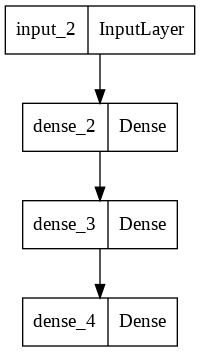

In [ ]:
keras.utils.plot_model(model, 'model.png')

# Learn more: https://colab.research.google.com/drive/1raWrM6AIO4kI-CiZ_DdiDzhJkLzS1MXi?usp=sharing


# By using Deep Q-Networks (DQN), we will solve an Open AI Gym environement 'Cartpole-v1': https://gym.openai.com/envs/CartPole-v1/


# This code is adapted from https://keras.io/examples/rl/deep_q_network_breakout/.


In [ ]:
import numpy as np
import tensorflow as tf
import gym
from tensorflow import keras
from tensorflow.keras import layers

# Configuration paramaters for the whole setup
gamma = 0.99  # Discount factor 
epsilon = 0.1  # Epsilon greedy parameter
batch_size = 32  # Size of batch taken from replay buffer
env =gym.make('CartPole-v1')

In [ ]:
num_actions = env.action_space.n

def create_q_model():
    inputs=layers.Input(shape=(4,))
    layer1=layers.Dense(512, activation="relu")(inputs)
    output=layers.Dense(num_actions, activation='linear')(layer1)

    return keras.Model(inputs=inputs, outputs=output)


# The first model makes the predictions for Q-values which are used to
model=create_q_model()
# Build a target model 
model_target=create_q_model()

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_5 (Dense)             (None, 512)               2560      
                                                                 
 dense_6 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 3,586
Trainable params: 3,586
Non-trainable params: 0
_________________________________________________________________


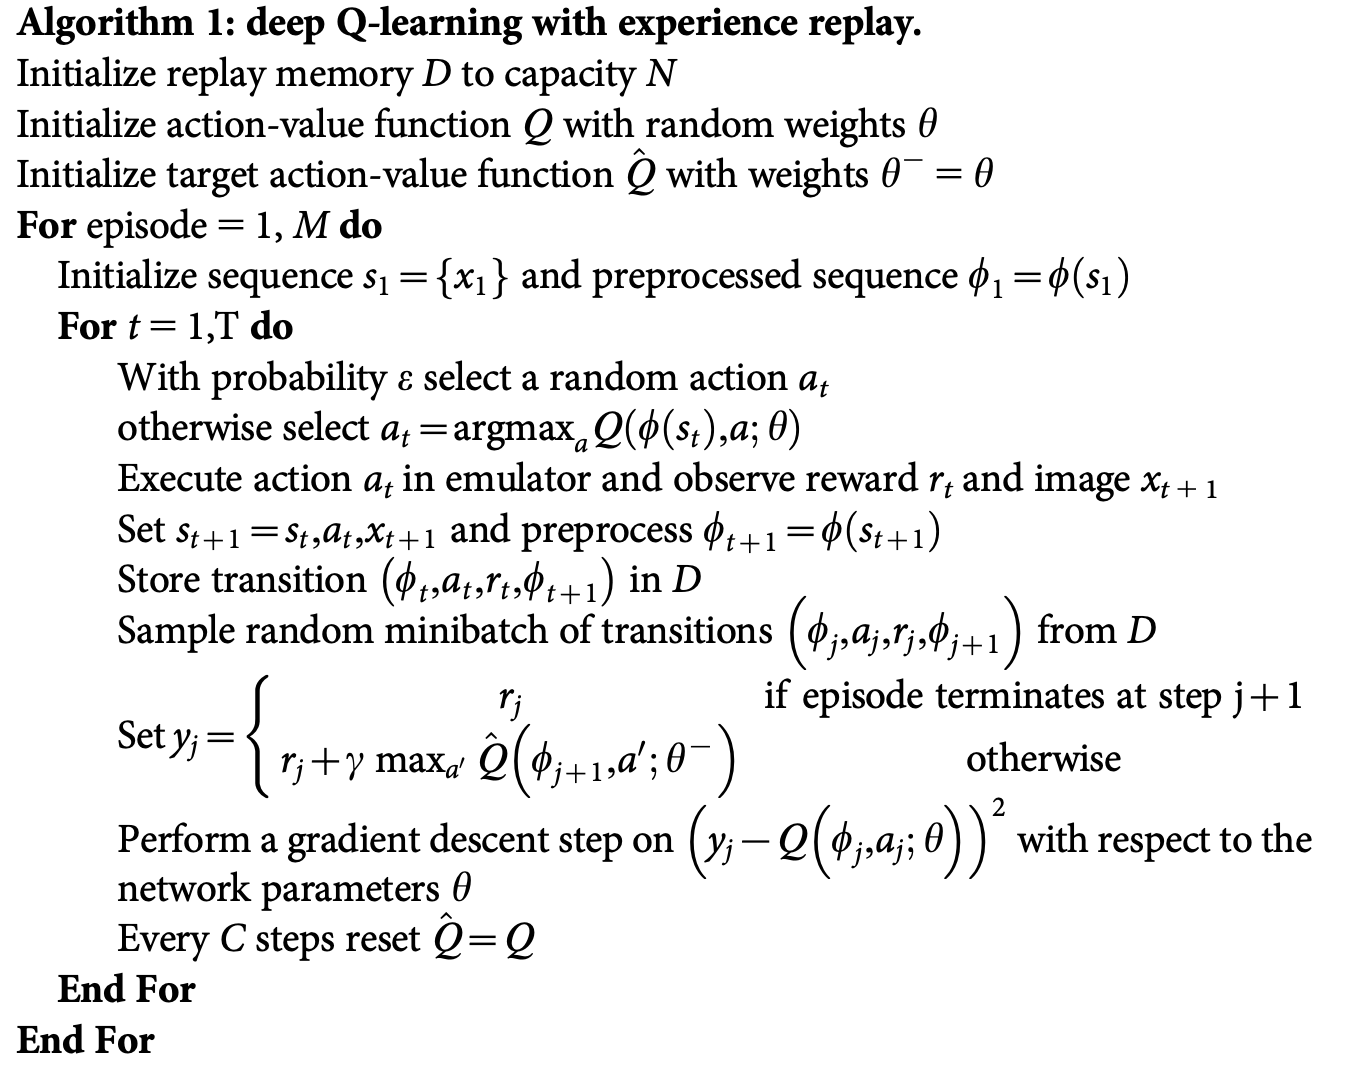

In [12]:
#Optimizer
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
# huber loss 
loss_function = keras.losses.Huber()

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
time_count = 0

max_memory_length = 10000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 1000

while True:  # Run until solved
    state = np.array(env.reset())
    episode_reward = 0
    Termination= False
    while Termination != True:
        # env.render(); Adding this line would show the attempts
        # of the agent in a pop up window.
        time_count += 1

        # Use epsilon-greedy for exploration
        if epsilon > np.random.rand(1)[0]:
            # Take random action
            action=np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            state_tensor=tf.convert_to_tensor(state)
            state_tensor=tf.expand_dims(state_tensor,0)
            action_value=model(state_tensor, training=False)
            # Take best action
            action=tf.argmax(action_value[0]).numpy()

        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state=state_next

        # Update every fourth time count and once batch size is over 32
        if time_count % update_after_actions == 0 and len(done_history) > batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model 
            future_rewards = model_target.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If terminal state, then updated Q value is equal to the terminal reward (0)
            updated_q_values = updated_q_values * (1 - done_sample) 

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)
            #we open a `GradientTape()` scope.
            #Inside this scope, we call the model (forward pass) 
            #and compute the loss. 
            #The operations that the model applies to the inputs are recorded 
            #on the `GradientTape()`
            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to 
                #get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            #We retrieve the gradients of the weights 
            #of the model with regard to the loss.
            #Finally, we use the optimizer to update 
            #the weights of the model based on the gradients
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if time_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, time count {}"
            print(template.format(running_reward, episode_count, time_count))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            Termination=True

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)


    episode_count += 1

    if running_reward > 190:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

running reward: 9.95 at episode 100, time count 1000
running reward: 9.80 at episode 202, time count 2000
running reward: 9.99 at episode 302, time count 3000
running reward: 10.08 at episode 401, time count 4000
running reward: 9.94 at episode 501, time count 5000
running reward: 10.04 at episode 601, time count 6000
running reward: 9.97 at episode 701, time count 7000
running reward: 9.88 at episode 802, time count 8000
running reward: 10.95 at episode 893, time count 9000
running reward: 10.73 at episode 986, time count 10000
running reward: 10.30 at episode 1084, time count 11000
running reward: 11.21 at episode 1173, time count 12000
running reward: 10.93 at episode 1264, time count 13000
running reward: 11.37 at episode 1352, time count 14000
running reward: 12.17 at episode 1433, time count 15000
running reward: 14.55 at episode 1500, time count 16000
running reward: 17.22 at episode 1557, time count 17000
running reward: 20.26 at episode 1598, time count 18000
running reward: 2